In [282]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

## Lotka Verterra dynamics
We first check the steady state of Lotka Verterra dynamics from direct simulation.

In [292]:
#debug cavity solution by looking at lotka voterna, turns out no problem
def lotka_volterra(t, X):
    return X*(k -X- alpha@X)
mu=1
sigma=0.3
gamma=1
S=100

Xmean=[]
Xsqmean=[]
phiX=[]


for i in range(100):
    X=np.random.normal(0, 1, (S,S))
    Z=np.triu(X)+gamma*np.transpose(np.triu(X))+np.sqrt(1-gamma**2)*(np.tril(X))
    alpha=sigma*Z/np.sqrt(S)+mu/S
    k=np.random.normal(1, 1, S)
    
    initial_state=np.random.uniform(0,2,S)
    sol_LV = solve_ivp(lotka_volterra, t_span=[0,200], y0=initial_state, dense_output=True)
    
    Xmean.append(np.mean(sol_LV.y.T[-1]))
    
    Xsqmean.append(np.mean(sol_LV.y.T[-1]**2))
    phiX.append(sum(sol_LV.y.T[-1]> 1e-11))
#plt.plot(sol_LV.t, sol_LV.y.T)

print('<X>, <X^2>, PhiX',np.mean(Xmean),np.mean(Xsqmean),np.mean(phiX)/S)

<X>, <X^2>, PhiX 0.6536777070058095 1.0283583466913808 0.6696


## 3-layer consumer resource - single parameter set
Here we find out statistical property steady state of the 3 layer consumer resource model by direct integration of ODE. The result is averaged over different C and D with the same statistical property.

In [291]:

'''to check 2 layers, put 
D_mean = 0
D_std_dev = 0,
and the comment out rata recorder for X-related quantity 

'''
top_species = 25 #W
middle_species = 50 #B
resources = 100 #R

# Set the statistics for the consumer-preference matrices
D_mean = 1
D_std_dev = 1

C_mean = 1
C_std_dev = 1

def consumer_resource(t, state):
        X = state[:top_species]
        N = state[top_species:top_species+middle_species]
        R = state[top_species+middle_species:]
        
        dX = X*(np.dot(D,N)-u)
        dN = N*(np.dot(C,R)-m-np.dot(D.T,X))
        dR = R*(k-R-np.dot(C.T,N))
        
        return np.concatenate((dX,dN,dR),axis=None)

Xmean=[]
Nmean=[]
Rmean=[]

Xsqmean=[]
Nsqmean=[]
Rsqmean=[]

phiX=[]
phiN=[]
phiR=[]

for i in range(40): # average over different C and D
    
    D = D_mean/middle_species + D_std_dev*np.random.normal(0, 1, (top_species,middle_species))/np.sqrt(middle_species)
    C = C_mean/resources+C_std_dev*np.random.normal(0, 1, (middle_species,resources))/np.sqrt(resources)

    u = np.random.normal(1,1,top_species)
    m = np.random.normal(1,1,middle_species)
    k = np.random.normal(1,1,resources)
    #initial_state[:top_species]=0 #for debug

    initial_state = np.random.uniform(0,1,top_species+middle_species+resources)
    
    sol = solve_ivp(consumer_resource, t_span=[0,400], y0=initial_state.copy(), dense_output=True,method='LSODA')

    Xmean.append(np.average(sol.y[:top_species].T[-1]))
    Nmean.append(np.average(sol.y[top_species:top_species+middle_species].T[-1]))
    Rmean.append(np.average(sol.y[top_species+middle_species:].T[-1]))
    
    Xsqmean.append(np.average(sol.y[:top_species].T[-1]**2))
    Nsqmean.append(np.average(sol.y[top_species:top_species+middle_species].T[-1]**2))
    Rsqmean.append(np.average(sol.y[top_species+middle_species:].T[-1]**2))
    
    
    phiX.append(sum(sol.y[:top_species].T[-1]> 1e-11))
    phiN.append(sum(sol.y[top_species:top_species+middle_species].T[-1]> 1e-11))
    phiR.append(sum(sol.y[top_species+middle_species:].T[-1]> 1e-11))
    


print('phiX, phiN, phiR:',np.mean(phiX)/top_species,np.mean(phiN)/middle_species,np.mean(phiR)/resources)

print('<X>, <N>, <R>:', np.average(Xmean),np.average(Nmean),np.average(Rmean))
#1.194553440194546 0.49940593471836237 0.8342422570461712

print('<X^2>, <N^2>, <R^2>:',np.average(Xsqmean),np.average(Nsqmean),np.average(Rsqmean))
#50.209235853789444 1.1655278869000927 1.9306360571794994

phiX, phiN, phiR: 0.391 0.402 0.73625
<X>, <N>, <R>: 1.2885410375852842 0.5476014797976667 0.8197420037900696
<X^2>, <N^2>, <R^2>: 11.941573537992229 1.2229677152760892 1.3695256942598584


## 3-layer consumer resource -vary over r
After checking single set of parameters for 3 layer consumer resource model, we can check it for a varying set of parameters. The cavity solution is copied from Mathematica

In [226]:
#{x, qx, R, qr, n, qn, w0[deltaue], w0[deltame], w0[deltake]}
mathematica=[[1.04269, 4.44386, 0.866828, 1.45442, 0.590032, 1.38853, 0.395402, 
  0.404265, 0.746715], [1.03054, 4.21397, 0.883391, 1.4914, 0.624014, 
  1.50722, 0.406153, 0.415341, 0.753958], [1.025, 4.07802, 0.898193, 
  1.52442, 0.650874, 1.60014, 0.414294, 0.424577, 0.76041], [1.02254, 
  3.99065, 0.911281, 1.55352, 0.672484, 1.67387, 0.420626, 0.432371, 
  0.76613], [1.02165, 3.93114, 0.922832, 1.5791, 0.690176, 1.73327, 
  0.425673, 0.439023, 0.771193], [1.02159, 3.88884, 0.93305, 1.60163, 
  0.704891, 1.78189, 0.42978, 0.444757, 0.775683], [1.02198, 3.85775, 
  0.942121, 1.62157, 0.717305, 1.82227, 0.433184, 0.449745, 
  0.779678], [1.02263, 3.83428, 0.950211, 1.6393, 0.727909, 1.85625, 
  0.436048, 0.454121, 0.783244], [1.0234, 3.81619, 0.95746, 1.65514, 
  0.737066, 1.88519, 0.438491, 0.457988, 0.786442], [1.02424, 3.80199,
   0.963986, 1.66936, 0.745052, 1.91009, 0.440599, 0.461429, 
  0.789322], [1.0251, 3.79068, 0.969886, 1.6822, 0.752076, 1.93173, 
  0.442436, 0.464509, 0.791926], [1.02596, 3.78154, 0.975244, 1.69383,
   0.7583, 1.95069, 0.444051, 0.467282, 0.794291], [1.02679, 3.77409, 
  0.980129, 1.70442, 0.763853, 1.96744, 0.445482, 0.469792, 0.796445]]

In [297]:
'''for varied r1 r2'''
D_mean = 1
D_std_dev = 1

C_mean = 1
C_std_dev = 1

# Create the matrices and vectors featured in the differential equations

# C = C[:,resources_survived]
# D = D[top_survived,:]

# u = u[top_survived]
# m = m
# k = k[resources_survived]



rinlist=np.linspace(3,9,13)
        
qs=[]
phis=[]
means=[]
    
qse=[]
phise=[]
meanse=[]
for rin in rinlist:
    top_species = 20 #W
    middle_species = int(top_species*rin) #B
    resources = int(middle_species*rin) #R

    print(middle_species)
   
    # Set the statistics for the consumer-preference matrices
    D_mean = 1
    D_std_dev = 1

    C_mean = 1
    C_std_dev = 1


    def consumer_resource(t, state):
            X = state[:top_species]
            N = state[top_species:top_species+middle_species]
            R = state[top_species+middle_species:]

            dX = X*(np.dot(D,N)-u)
            dN = N*(np.dot(C,R)-m-np.dot(D.T,X))
            dR = R*(k-R-np.dot(C.T,N))

            return np.concatenate((dX,dN,dR),axis=None)

    Xmean=[]
    Nmean=[]
    Rmean=[]

    Xsqmean=[]
    Nsqmean=[]
    Rsqmean=[]

    phiX=[]
    phiN=[]
    phiR=[]
    
    for i in range(20):

        D = D_mean/middle_species + D_std_dev*np.random.normal(0, 1, (top_species,middle_species))/np.sqrt(middle_species)
        C = C_mean/resources+C_std_dev*np.random.normal(0, 1, (middle_species,resources))/np.sqrt(resources)

        u = np.random.normal(1,1,top_species)
        m = np.random.normal(1,1,middle_species)
        k = np.random.normal(1,1,resources)
        #initial_state[:top_species]=0 #for debug

        initial_state = np.random.uniform(0,1,top_species+middle_species+resources)

        sol = solve_ivp(consumer_resource, t_span=[0,400], y0=initial_state.copy(), dense_output=True,method='LSODA')

        Xmean.append(np.average(sol.y[:top_species].T[-1]))
        Nmean.append(np.average(sol.y[top_species:top_species+middle_species].T[-1]))
        Rmean.append(np.average(sol.y[top_species+middle_species:].T[-1]))

        Xsqmean.append(np.average(sol.y[:top_species].T[-1]**2))
        Nsqmean.append(np.average(sol.y[top_species:top_species+middle_species].T[-1]**2))
        Rsqmean.append(np.average(sol.y[top_species+middle_species:].T[-1]**2))


        phiX.append(sum(sol.y[:top_species].T[-1]> 1e-11))
        phiN.append(sum(sol.y[top_species:top_species+middle_species].T[-1]> 1e-11))
        phiR.append(sum(sol.y[top_species+middle_species:].T[-1]> 1e-11))


    qs.append([np.mean(Xsqmean),np.mean(Nsqmean),np.mean(Rsqmean)]),
    means.append([np.mean(Xmean),np.mean(Nmean),np.mean(Rmean)])
    phis.append([np.mean(phiX)/top_species,np.mean(phiN)/middle_species,np.mean(phiR)/resources])
    
    qse.append([np.std(Xsqmean),np.std(Nsqmean),np.std(Rsqmean)]),
    meanse.append([np.std(Xmean),np.std(Xsqmean),np.std(phiX)/S])
    phise.append([np.std(phiX)/top_species,np.std(phiN)/middle_species,np.std(phiR)/resources])





60
70
80
90
100
110
120
130
140
150
160
170
180


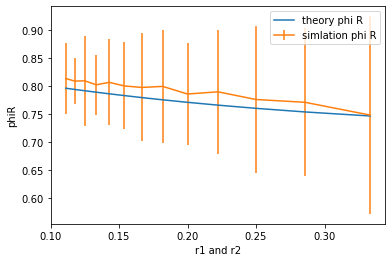

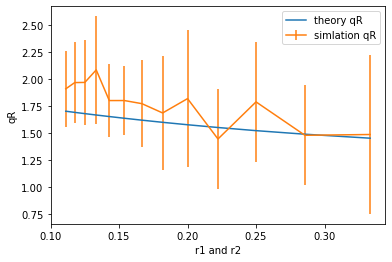

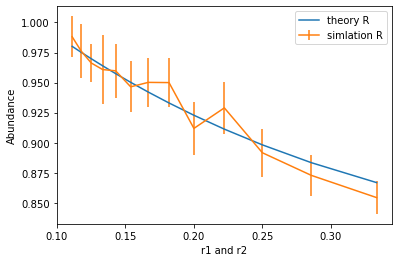

In [300]:
qs=np.array(qs)
means=np.array(means)
phis=np.array(phis)

qse=np.array(qse)
meanse=np.array(meanse)
phise=np.array(phise)
plt.figure()
plt.plot(1/rinlist, mathematica[:,-1],label='theory phi R')
plt.errorbar(1/rinlist,phis[:,-1],yerr=qse[:,-1],label='simlation phi R')

plt.xlabel('r1 and r2')
plt.ylabel('phiR')
plt.legend()
plt.show()



plt.figure()
plt.plot(1/rinlist, mathematica[:,3],label='theory qR')
plt.errorbar(1/rinlist,qs[:,1],yerr=qse[:,1],label='simlation qR')

plt.xlabel('r1 and r2')
plt.ylabel('qR')
plt.legend()
plt.show()





plt.figure()
#plt.plot(1/rinlist[:-2], mathematica[:,0],label='theory x')
#plt.errorbar(1/rinlist,means[:,0],yerr=meanse[:,0],label='simlation x')

plt.plot(1/rinlist, mathematica[:,2],label='theory R')
plt.errorbar(1/rinlist,means[:,2],yerr=meanse[:,2],label='simlation R')

#plt.plot(1/rinlist[:-2], mathematica[:,0],label='theory x')
#plt.errorbar(1/rinlist,means[:,0],yerr=meanse[:,2],label='simlation x')
plt.xlabel('r1 and r2')
plt.ylabel('Abundance')
plt.legend()
plt.show()

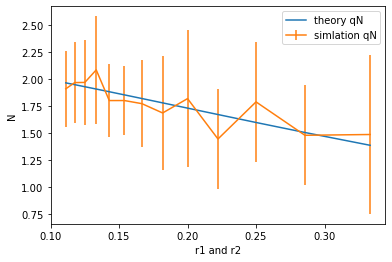

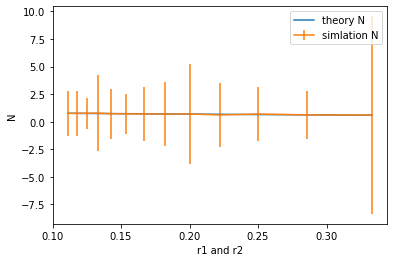

In [302]:
plt.figure()
plt.plot(1/rinlist, mathematica[:,5],label='theory qN')
plt.errorbar(1/rinlist,qs[:,1],yerr=qse[:,1],label='simlation qN')

plt.xlabel('r1 and r2')
plt.ylabel('N')
plt.legend()
plt.show()

plt.figure()
plt.plot(1/rinlist, mathematica[:,4],label='theory N')
plt.errorbar(1/rinlist,means[:,1],yerr=meanse[:,1],label='simlation N')

plt.xlabel('r1 and r2')
plt.ylabel('N')
plt.legend()
plt.show()

In [228]:
mathematica=np.array(mathematica)
mathematica[:,0]

array([1.04269, 1.03054, 1.025  , 1.02254, 1.02165, 1.02159, 1.02198,
       1.02263, 1.0234 , 1.02424, 1.0251 , 1.02596, 1.02679])

## Checking optimization and cavity
We have checked before that the steady-state solution to the differential equations is equivalent to this optimization problem:

\begin{align*}
\min_N (-\sum_{i\beta} N_i &(c_{i\beta}K_\beta-m_i)+\frac{1}{2}\sum_{ij}\phi_{ij} N_jN_i) \\
\phi_{ij}&=\sum_{ \beta}c_{i\beta} c_{j\beta} 
\end{align*}

subject to
\begin{align*}
\sum_i d_{ai}N_i &\leq u_a \\
N_i&\geq0
\end{align*}

But when m and u are random, some error occur

In [305]:
Nmean=[]
Xmean=[]
Nq=[]
Xq=[]
Xphi=[]
Nphi=[]

Nmeane=[]
Xmeane=[]
Nqe=[]
Xqe=[]
Xphie=[]
Nphie=[]
rinlist=np.linspace(3,9,13)
        
for rin in rinlist:
    top_species = 40 #W
    middle_species = int(top_species*rin) #B
    resources = int(middle_species*rin) #R
    N_opt_mean=[]
    N_opt_q=[]
    X_opt_mean=[]
    X_opt_q=[]
    phiN=[]
    phiX=[]
    
    for i in range(100):

        D = D_mean/middle_species + D_std_dev*np.random.normal(0, 1, (top_species,middle_species))/np.sqrt(middle_species)
        C = C_mean/resources+C_std_dev*np.random.normal(0, 1, (middle_species,resources))/np.sqrt(resources)

        u = np.random.normal(1,1,top_species)
        m = np.random.normal(1,1,middle_species)
        k = np.random.normal(1,1,resources)
        
        
        N_opt = cvx.Variable(middle_species)
        constraints=[D @ N_opt <= u, N_opt >= 0]
        
        prob = cvx.Problem(cvx.Minimize(-N_opt@(np.dot(C,k).T - m) + 0.5*cvx.quad_form(N_opt, np.dot(C,C.T)) ), constraints)
        prob_output = prob.solve()

        Ns=N_opt.value
        Xs=constraints[0].dual_value

        N_opt_mean.append(np.mean(Ns))
        N_opt_q.append(np.mean(Ns**2))
        X_opt_mean.append(np.mean(Xs))
        X_opt_q.append(np.mean(Xs**2))
        
        phiN.append(sum(Ns> 1e-11))
        phiX.append(sum(Xs> 1e-11))
        
    Nmean.append(np.mean(N_opt_mean))
    Xmean.append(np.mean(X_opt_mean))
    Nq.append(np.mean(N_opt_q))
    Xq.append(np.mean(X_opt_q))
    Nphi.append(np.mean(phiN))
    Xphi.append(np.mean(phiX))

    Nmeane.append(np.std(N_opt_mean))
    Xmeane.append(np.std(X_opt_mean))
    Nqe.append(np.std(N_opt_q))
    Xqe.append(np.std(X_opt_q))
    Nphie.append(np.std(phiN))
    Xphie.append(np.std(phiX))
        
    

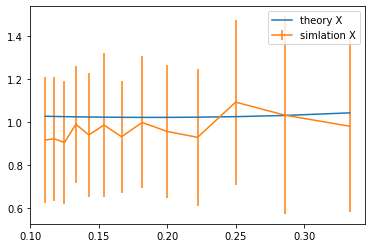

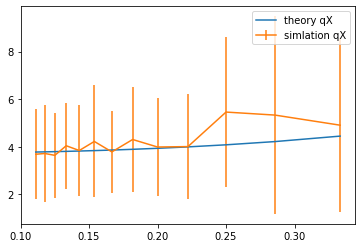

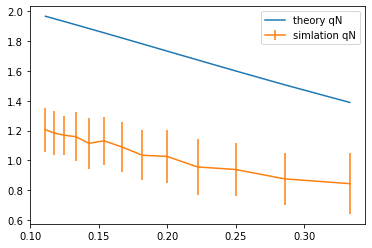

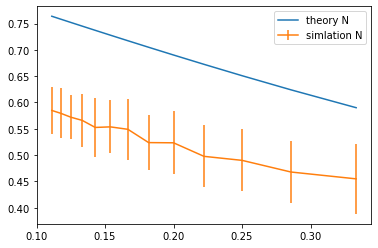

In [306]:
plt.plot(1/rinlist, mathematica[:,0],label='theory X')
plt.errorbar(1/rinlist,Xmean,yerr=Xmeane,label='simlation X')
plt.legend()
plt.show()

plt.figure()

plt.plot(1/rinlist, mathematica[:,1],label='theory qX')
plt.errorbar(1/rinlist,Xq,yerr=Xqe,label='simlation qX')
plt.legend()
plt.show()

plt.plot(1/rinlist, mathematica[:,5],label='theory qN')
plt.errorbar(1/rinlist,Nq,yerr=Nqe,label='simlation qN')
plt.legend()
plt.show()

plt.plot(1/rinlist, mathematica[:,4],label='theory N')
plt.errorbar(1/rinlist,Nmean,yerr=Nmeane,label='simlation N')
plt.legend()
plt.show()